## Test 1

In [9]:
import os
import json
from mathutils import Matrix

# Specify the path to the dataset folder
dataset_path = 'data/3RScan'

scenes = {}

for scan_folder in os.listdir(dataset_path):
    scan_folder_path = os.path.join(dataset_path, scan_folder)

    # Check if the folder contains semseg.v2.json file
    semseg_file = os.path.join(scan_folder_path, 'semseg.v2.json')
    if not os.path.isfile(semseg_file):
        continue

    # Read and parse the semseg.v2.json file
    with open(semseg_file, 'r') as file:
        semseg_data = json.load(file)

    scan_id = semseg_data['scan_id']
    seg_groups = semseg_data['segGroups']
    
    extracted_objects = []

    # Extract individual objects
    for object_data in seg_groups:
        obj = {}
        # Extract necessary data from JSON
        axes_lengths = object_data['obb']['axesLengths']
        centroid = object_data['obb']['centroid']
        normalized_axes = object_data['obb']['normalizedAxes']
        
        # Create a transformation matrix for the object
        # Reshape normalized_axes into a 3x3 matrix
        matrix_data = [normalized_axes[i:i + 3] for i in range(0, 9, 3)]
        
        # Create a transformation matrix for the object
        matrix = Matrix(matrix_data).to_4x4()
        matrix.translation = centroid
        
        # Extract location, size, and rotation from the matrix
        location = matrix.translation
        size = axes_lengths
        rotation = matrix.to_euler()
        
        # Print the extracted data for each object
        print("Object ID:", object_data['objectId'])
        obj['id'] = object_data['objectId']
        print("Location:", location)
        obj['location'] = location
        print("Size:", size)
        obj['size'] = size
        print("Rotation:", rotation)
        obj['rotation'] = rotation
        print("---")
        
        extracted_objects.append(obj)
    
    scenes[scan_id] = extracted_objects


Object ID: 14
Location: Vector((-0.5973531007766724, -2.555398464202881, 0.2100500464439392))
Size: [4.43563043578445, 3.2909999350234864, 0.214380383343314]
Rotation: Euler((-1.5707963705062866, -2.341798782348633, -0.0), 'XYZ')
---
Object ID: 27
Location: Vector((0.7632876634597778, -3.4580538272857666, -0.8209295272827148))
Size: [1.5918959532736994, 1.228481026847339, 1.53071979496876]
Rotation: Euler((-1.5707963705062866, -1.6765729188919067, -0.0), 'XYZ')
---
Object ID: 4
Location: Vector((-1.1800059080123901, 0.5172972083091736, -0.6096214652061462))
Size: [3.6497809745206014, 0.520757007879979, 0.8072537431597383]
Rotation: Euler((-1.5707963705062866, -0.8299843668937683, 0.0), 'XYZ')
---
Object ID: 10
Location: Vector((-0.7376044392585754, 1.358355164527893, 0.3739544749259949))
Size: [1.9356489876150313, 1.7643309437260557, 0.5290871141518507]
Rotation: Euler((-1.5707963705062866, -0.9470512270927429, 0.0), 'XYZ')
---
Object ID: 3
Location: Vector((-1.1051522493362427, 0.3544

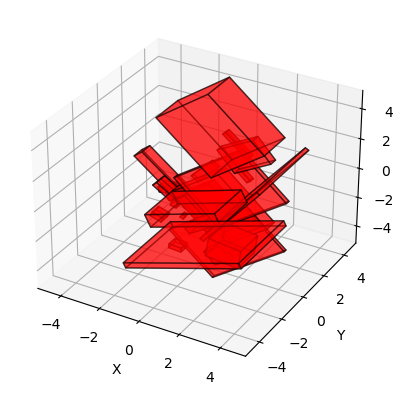

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize objects in the scene
for object_data in scenes['4acaebcc-6c10-2a2a-858b-29c7e4fb410d']:
    # Extract necessary data from the object
    location = object_data['location']
    size = object_data['size']
    rotation = object_data['rotation']

    # Extract x, y, z coordinates for plotting
    x, y, z = location

    # Extract width, height, depth for size of the object
    width, height, depth = size

    # Create a rotation matrix based on the Euler angles
    rotation_matrix = rotation.to_matrix()

    # Create the vertices of the bounding box
    vertices = [
        (x - width/2, y - height/2, z - depth/2),
        (x + width/2, y - height/2, z - depth/2),
        (x + width/2, y + height/2, z - depth/2),
        (x - width/2, y + height/2, z - depth/2),
        (x - width/2, y - height/2, z + depth/2),
        (x + width/2, y - height/2, z + depth/2),
        (x + width/2, y + height/2, z + depth/2),
        (x - width/2, y + height/2, z + depth/2)
    ]

    # Rotate the vertices
    rotated_vertices = [np.dot(rotation_matrix, np.array(vertex)) for vertex in vertices]

    # Create a collection of polygons for the bounding box
    polygons = [
        [rotated_vertices[0], rotated_vertices[1], rotated_vertices[2], rotated_vertices[3]],
        [rotated_vertices[4], rotated_vertices[5], rotated_vertices[6], rotated_vertices[7]],
        [rotated_vertices[0], rotated_vertices[1], rotated_vertices[5], rotated_vertices[4]],
        [rotated_vertices[2], rotated_vertices[3], rotated_vertices[7], rotated_vertices[6]],
        [rotated_vertices[0], rotated_vertices[3], rotated_vertices[7], rotated_vertices[4]],
        [rotated_vertices[1], rotated_vertices[2], rotated_vertices[6], rotated_vertices[5]]
    ]

    # Create the 3D collection and add it to the plot
    collection = Poly3DCollection(polygons, alpha=0.5, facecolor='red', edgecolor='black')
    ax.add_collection3d(collection)

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits of the plot's axes
factor = 5
x_min, x_max, y_min, y_max, z_min, z_max = -factor, factor, -factor, factor, -factor, factor
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

# Show the plot
plt.show()


## Test 2

In [21]:
import os
import json

def preprocess_dataset(dataset_path):
    scene_matrices = {}
    object_labels = {}

    # Iterate over the folders in the dataset path
    for scan_folder in os.listdir(dataset_path):
        scan_folder_path = os.path.join(dataset_path, scan_folder)

        # Check if the folder contains semseg.v2.json file
        semseg_file = os.path.join(scan_folder_path, 'semseg.v2.json')
        if not os.path.isfile(semseg_file):
            continue

        # Read and parse the semseg.v2.json file
        with open(semseg_file, 'r') as file:
            semseg_data = json.load(file)

        scan_id = semseg_data['scan_id']
        seg_groups = semseg_data['segGroups']
        
        scene_rows = []
        labels_mapping = {}

        # Iterate over the segGroups and extract object information
        for seg_group in seg_groups:
            object_id = seg_group['objectId']
            label = seg_group['label']
            centroid = seg_group['obb']['centroid']
            axes_lengths = seg_group['obb']['axesLengths']

            # Create a scene matrix row for the current object
            scene_row = [object_id] + centroid + axes_lengths
            scene_rows.append(scene_row)

            # Store the object label as a tuple
            labels_mapping[object_id] = label
        
        scene_matrices[scan_id] = scene_rows
        object_labels[scan_id] = labels_mapping

    return scene_matrices, object_labels

# Specify the path to the dataset folder
dataset_path = 'data/3RScan'

# Preprocess the dataset
scene_matrices, object_labels = preprocess_dataset(dataset_path)

# Print the scene matrices
for scan_id, scene_matrix in scene_matrices.items():
    print(f"\n\nScan ID: {scan_id}, Scene Matrix:")
    for row in scene_matrix:
        print(row)


# Print the object labels
for scan_id, labels in object_labels.items():
    print(f"\n\nScan ID: {scan_id}, Labels:")
    for object_id, label in labels.items():
        print(f"{object_id}: {label}")



Scan ID: 754e884c-ea24-2175-8b34-cead19d4198d, Scene Matrix:
[14, -0.5973530983700146, -2.555398581097461, 0.2100500473368907, 4.43563043578445, 3.2909999350234864, 0.214380383343314]
[27, 0.7632876486718007, -3.4580537226543733, -0.820929503345574, 1.5918959532736994, 1.228481026847339, 1.53071979496876]
[4, -1.1800058887291685, 0.5172971928846, -0.6096214757944305, 3.6497809745206014, 0.520757007879979, 0.8072537431597383]
[10, -0.7376044179106434, 1.3583551495191042, 0.3739544721553969, 1.9356489876150313, 1.7643309437260557, 0.5290871141518507]
[3, -1.1051522876580964, 0.3544662283574396, 0.21000003904104192, 3.9398105232542577, 3.279999898076058, 1.1186110857208948]
[11, -1.2471097954782961, 0.6115875000099775, 0.31276452401061694, 3.622007219801772, 1.7944709853573653, 0.601493512487408]
[8, -1.8586228126914182, -0.06296598512204765, -0.3499999955296511, 0.5543277062034465, 0.39999999701976763, 0.37604559626232714]
[13, -2.025811316545459, -0.4211309230192375, -0.19726998849354

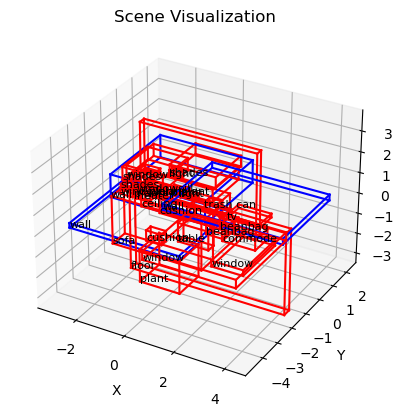

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract a single scene matrix from the dictionary
scene_matrix = list(scene_matrices.values())[0]
label_mapping = list(object_labels.values())[0]

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Iterate over the objects in the scene matrix
for obj_data in scene_matrix:
    # Extract the object information
    obj_id = obj_data[0]
    obj_centroid = obj_data[1:4]
    obj_axes_lengths = obj_data[4:7]

    # Get the label for the object
    obj_label = label_mapping.get(obj_id, "Unknown")

    # Compute the coordinates of the bounding box vertices
    x = [obj_centroid[0] - obj_axes_lengths[0] / 2, obj_centroid[0] + obj_axes_lengths[0] / 2]
    y = [obj_centroid[1] - obj_axes_lengths[1] / 2, obj_centroid[1] + obj_axes_lengths[1] / 2]
    z = [obj_centroid[2] - obj_axes_lengths[2] / 2, obj_centroid[2] + obj_axes_lengths[2] / 2]

    # Plot the bounding box with a color based on the label
    color = "r"  # Default color
    if obj_label == "wall":
        color = "b"
    # Add more label-color mappings as needed

    ax.plot([x[0], x[1]], [y[0], y[0]], [z[0], z[0]], color=color)  # Bottom edge
    ax.plot([x[0], x[1]], [y[1], y[1]], [z[0], z[0]], color=color)  # Top edge
    ax.plot([x[0], x[0]], [y[0], y[1]], [z[0], z[0]], color=color)  # Left edge
    ax.plot([x[1], x[1]], [y[0], y[1]], [z[0], z[0]], color=color)  # Right edge

    ax.plot([x[0], x[1]], [y[0], y[0]], [z[1], z[1]], color=color)  # Bottom edge
    ax.plot([x[0], x[1]], [y[1], y[1]], [z[1], z[1]], color=color)  # Top edge
    ax.plot([x[0], x[0]], [y[0], y[1]], [z[1], z[1]], color=color)  # Left edge
    ax.plot([x[1], x[1]], [y[0], y[1]], [z[1], z[1]], color=color)  # Right edge

    ax.plot([x[0], x[0]], [y[0], y[0]], [z[0], z[1]], color=color)  # Vertical edge
    ax.plot([x[1], x[1]], [y[0], y[0]], [z[0], z[1]], color=color)  # Vertical edge
    ax.plot([x[0], x[0]], [y[1], y[1]], [z[0], z[1]], color=color)  # Vertical edge
    ax.plot([x[1], x[1]], [y[1], y[1]], [z[0], z[1]], color=color)  # Vertical edge

    # Annotate the bounding box with the label
    ax.text(x[0], y[0], z[0], obj_label, color='black', fontsize=8)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Scene Visualization')

# Show the plot
plt.show()